# Typical architecture of a classification neural network 

The word *typical* is on purpose.

Because the architecture of a classification neural network can widely vary depending on the problem you're working on.

However, there are some fundamentals all deep neural networks contain:
* An input layer.
* Some hidden layers.
* An output layer.

Much of the rest is up to the data analyst creating the model.

The following are some standard values you'll often use in your classification neural networks.

| **Hyperparameter** | **Binary Classification** | **Multiclass classification** |
| --- | --- | --- |
| Input layer shape | Same as number of features (e.g. 5 for age, sex, height, weight, smoking status in heart disease prediction) | Same as binary classification |
| Hidden layer(s) | Problem specific, minimum = 1, maximum = unlimited | Same as binary classification |
| Neurons per hidden layer | Problem specific, generally 10 to 100 | Same as binary classification |
| Output layer shape | 1 (one class or the other) | 1 per class (e.g. 3 for food, person or dog photo) |
| Hidden activation | Usually [ReLU](https://www.kaggle.com/dansbecker/rectified-linear-units-relu-in-deep-learning) (rectified linear unit) | Same as binary classification |
| Output activation | [Sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function) | [Softmax](https://en.wikipedia.org/wiki/Softmax_function) |
| Loss function | [Cross entropy](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_loss_function_and_logistic_regression) ([`tf.keras.losses.BinaryCrossentropy`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy) in TensorFlow) | Cross entropy ([`tf.keras.losses.CategoricalCrossentropy`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy) in TensorFlow) |
| Optimizer | [SGD](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD) (stochastic gradient descent), [Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) | Same as binary classification |

***Table 1:*** *Typical architecture of a classification network.* ***Source:*** *Adapted from page 295 of [Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow Book by Aurélien Géron](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/)*

Don't worry if not much of the above makes sense right now, we'll get plenty of experience as we go through this notebook.

Let's start by importing TensorFlow as the common alias `tf`. For this notebook, make sure you're using version 2.x+.

In [1]:
import tensorflow as tf
print(tf.__version__)

2.6.0


# Creating data to view and fit

We could start by importing a classification dataset but let's practice making some of our own classification data.

> 🔑 **Note:** It's a common practice to get you and model you build working on a toy (or simple) dataset before moving to your actual problem. Treat it as a rehersal experiment before the actual experiment(s).

Since classification is predicting whether something is one thing or another, let's make some data to reflect that.

To do so, we'll use Scikit-Learn's [`make_circles()`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_circles.html#sklearn.datasets.make_circles) function.



In [2]:
from sklearn.datasets import make_circles

# Make 1000 examples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples, 
                    noise=0.03, 
                    random_state=42)

Wonderful, now we've created some data, let's look at the features (`X`) and labels (`y`).

In [3]:
# Check out the features
X

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       ...,
       [-0.13690036, -0.81001183],
       [ 0.67036156, -0.76750154],
       [ 0.28105665,  0.96382443]])

In [4]:
# See the first 10 labels
y[:10]

array([1, 1, 1, 1, 0, 1, 1, 1, 1, 0])

Okay, we've seen some of our data and labels, how about we move towards visualizing?

> 🔑 **Note:** One important step of starting any kind of machine learning project is to [become one with the data](https://karpathy.github.io/2019/04/25/recipe/). And one of the best ways to do this is to visualize the data you're working with as much as possible. The data explorer's motto is "visualize, visualize, visualize".

We'll start with a DataFrame.

In [5]:
# Make dataframe of features and labels
import pandas as pd
circles = pd.DataFrame({"X0":X[:, 0], "X1":X[:, 1], "label":y})
circles.head()

,X0,X1,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


What kind of labels are we dealing with?

In [6]:
# Check out the different labels
circles.label.value_counts()

1    500
0    500
Name: label, dtype: int64

Alright, looks like we're dealing with a **binary classification** problem. It's binary because there are only two labels (0 or 1).

If there were more label options (e.g. 0, 1, 2, 3 or 4), it would be called **multiclass classification**.

Let's take our visualization a step further and plot our data.

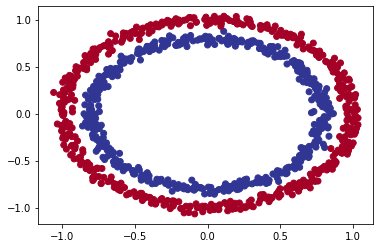

In [7]:
# Visualize with a plot
import matplotlib.pyplot as plt
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu);

Nice! From the plot, can you guess what kind of model we might want to build?

How about we try and build one to classify blue or red dots? As in, a model which is able to distinguish blue from red dots.

> 🛠 **Practice:** Before pushing forward, you might want to spend 10 minutes playing around with the [TensorFlow Playground](https://playground.tensorflow.org/#activation=relu&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=2,2&seed=0.93799&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&regularization_hide=true&regularizationRate_hide=true&batchSize_hide=true). Try adjusting the different hyperparameters you see and click play to see a neural network train. I think you'll find the data very similar to what we've just created.

# Input and output shapes

One of the most common issues you'll run into when building neural networks is shape mismatches.

More specifically, the shape of the input data and the shape of the output data.

In our case, we want to input `X` and get our model to predict `y`.

So let's check out the shapes of `X` and `y`.

In [8]:
# Check the shapes of our features and labels
X.shape, y.shape

((1000, 2), (1000,))

Hmm, where do these numbers come from?

In [9]:
# Check how many samples we have
len(X), len(y)

(1000, 1000)

So we've got as many `X` values as we do `y` values, that makes sense.

Let's check out one example of each.

In [10]:
# View the first example of features and labels
X[0], y[0]

(array([0.75424625, 0.23148074]), 1)

Alright, so we've got two `X` features which lead to one `y` value.

This means our neural network input shape will has to accept a tensor with at least one dimension being two and output a tensor with at least one value.

> 🤔 **Note:** `y` having a shape of (1000,) can seem confusing. However, this is because all `y` values are actually scalars (single values) and therefore don't have a dimension. For now, think of your output shape as being at least the same value as one example of `y` (in our case, the output from our neural network has to be at least one value).

# Steps in modelling

Now we know what data we have as well as the input and output shapes, let's see how we'd build a neural network to model it.

In TensorFlow, there are typically 3 fundamental steps to creating and training a model.

1. **Creating a model** - piece together the layers of a neural network yourself (using the [functional](https://www.tensorflow.org/guide/keras/functional) or [sequential API](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential)) or import a previously built model (known as transfer learning).
2. **Compiling a model** - defining how a model's performance should be measured (loss/metrics) as well as defining how it should improve (optimizer). 
3. **Fitting a model** - letting the model try to find patterns in the data (how does `X` get to `y`). 

Let's see these in action using the Sequential API to build a model for our regression data. And then we'll step through each.

In [11]:
# Set random seed
tf.random.set_seed(42)

# 1. Create the model using the Sequential API
model_1 = tf.keras.Sequential([
  tf.keras.layers.Dense(1)
])

# 2. Compile the model
model_1.compile(loss=tf.keras.losses.BinaryCrossentropy(), # binary since we are working with 2 clases (0 & 1)
                optimizer=tf.keras.optimizers.SGD(),
                metrics=['accuracy'])

# 3. Fit the model
model_1.fit(X, y, epochs=5)

Epoch 1/5
32/32 [==============================] - 2s 3ms/step - loss: 2.8544 - accuracy: 0.4600
Epoch 2/5
32/32 [==============================] - 0s 3ms/step - loss: 0.7131 - accuracy: 0.5430
Epoch 3/5
32/32 [==============================] - 0s 3ms/step - loss: 0.6973 - accuracy: 0.5090
Epoch 4/5
32/32 [==============================] - 0s 3ms/step - loss: 0.6950 - accuracy: 0.5010
Epoch 5/5
32/32 [==============================] - 0s 3ms/step - loss: 0.6942 - accuracy: 0.4830


Looking at the accuracy metric, our model performs poorly (50% accuracy on a binary classification problem is the equivalent of guessing), but what if we trained it for longer?

In [12]:
# Train our model for longer (more chances to look at the data)
model_1.fit(X, y, epochs=200, verbose=0) # set verbose=0 to remove training updates
model_1.evaluate(X, y)

32/32 [==============================] - 0s 2ms/step - loss: 0.6935 - accuracy: 0.5000


[0.6934829950332642, 0.5]

Even after 200 passes of the data, it's still performing as if it's guessing.

What if we added an extra layer and trained for a little longer?

In [13]:
# Set random seed
tf.random.set_seed(42)

# 1. Create the model (same as model_1 but with an extra layer)
model_2 = tf.keras.Sequential([
  tf.keras.layers.Dense(1), # add an extra layer
  tf.keras.layers.Dense(1) 
])

# 2. Compile the model
model_2.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.SGD(),
                metrics=['accuracy'])

# 3. Fit the model
model_2.fit(X, y, epochs=100, verbose=0) # set verbose=0 to make the output print less

In [14]:
# Evaluate the model
model_2.evaluate(X, y)

32/32 [==============================] - 0s 2ms/step - loss: 0.6933 - accuracy: 0.5000


[0.6933313608169556, 0.5]

Still not even as good as guessing (~50% accuracy)... hmm...?

Let's remind ourselves of a couple more ways we can use to improve our models.

# Improving a model

To improve our model, we can alter almost every part of the 3 steps we went through before.

1. **Creating a model** - here you might want to add more layers, increase the number of hidden units (also called neurons) within each layer, change the activation functions of each layer.
2. **Compiling a model** - you might want to choose a different optimization function (such as the [Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) optimizer, which is usually pretty good for many problems) or perhaps change the learning rate of the optimization function.
3. **Fitting a model** - perhaps you could fit a model for more epochs (leave it training for longer).

How about we try adding more neurons, an extra layer and our friend the Adam optimizer?

Surely doing this is better than guessing...

In [15]:
# Set random seed
tf.random.set_seed(42)

# 1. Create the model (this time 3 layers)
model_3 = tf.keras.Sequential([
  tf.keras.layers.Dense(100), # add 100 dense neurons
  tf.keras.layers.Dense(10), # add another layer with 10 neurons
  tf.keras.layers.Dense(1)
])

# 2. Compile the model
model_3.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(), # use Adam instead of SGD
                metrics=['accuracy'])

# 3. Fit the model
model_3.fit(X, y, epochs=100, verbose=0) # fit for 100 passes of the data

Still! 

We've pulled out a few tricks but our model isn't even doing better than guessing.

Let's make some visualizations to see what's happening.

> 🔑 **Note:** Whenever your model is performing strangely or there's something going on with your data you're not quite sure of, remember these three words: **visualize, visualize, visualize**. Inspect your data, inspect your model, inpsect your model's predictions.

To visualize our model's predictions we're going to create a function `plot_decision_boundary()` which:
* Takes in a trained model, features (`X`) and labels (`y`).
* Creates a [meshgrid](https://numpy.org/doc/stable/reference/generated/numpy.meshgrid.html) of the different `X` values.
* Makes predictions across the meshgrid.
* Plots the predictions as well as a line between the different zones (where each unique class falls).

If this sounds confusing, let's see it in code and then see the output.

> 🔑 **Note:** If you're ever unsure of what a function does, try unraveling it and writing it line by line for yourself to see what it does. Break it into small parts and see what each part outputs.

In [16]:
import numpy as np

def plot_decision_boundary(model, X, y):
  """
  Plots the decision boundary created by a model predicting on X.
  This function has been adapted from two phenomenal resources:
   1. CS231n - https://cs231n.github.io/neural-networks-case-study/
   2. Made with ML basics - https://github.com/madewithml/basics/blob/master/notebooks/09_Multilayer_Perceptrons/09_TF_Multilayer_Perceptrons.ipynb
  """
  # Define the axis boundaries of the plot and create a meshgrid
  x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
  y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
  xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                       np.linspace(y_min, y_max, 100))
  
  # Create X values (we're going to predict on all of these)
  x_in = np.c_[xx.ravel(), yy.ravel()] # stack 2D arrays together: https://numpy.org/devdocs/reference/generated/numpy.c_.html
  
  # Make predictions using the trained model
  y_pred = model.predict(x_in)

  # Check for multi-class
  if len(y_pred[0]) > 1:
    print("doing multiclass classification...")
    # We have to reshape our predictions to get them ready for plotting
    y_pred = np.argmax(y_pred, axis=1).reshape(xx.shape)
  else:
    print("doing binary classifcation...")
    y_pred = np.round(y_pred).reshape(xx.shape)
  
  # Plot decision boundary
  plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
  plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
  plt.xlim(xx.min(), xx.max())
  plt.ylim(yy.min(), yy.max())

Now we've got a function to plot our model's decision boundary (the cut off point its making between red and blue dots), let's try it out.

doing binary classifcation...


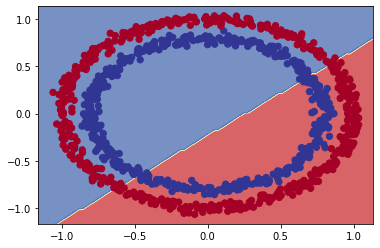

In [17]:
# Check out the predictions our model is making 
plot_decision_boundary(model_3, X, y)

# The missing piece: Non-linearity

Okay, so we saw our neural network can model straight lines (with ability a little bit better than guessing).

What about non-straight (non-linear) lines?

If we're going to model our classification data (the red and clue circles), we're going to need some non-linear lines.

> 🔨 **Practice:** Before we get to the next steps, I'd encourage you to play around with the [TensorFlow Playground](https://playground.tensorflow.org/#activation=linear&batchSize=1&dataset=circle&regDataset=reg-plane&learningRate=0.01&regularizationRate=0&noise=0&networkShape=1&seed=0.09561&showTestData=false&discretize=false&percTrainData=70&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&regularizationRate_hide=true&discretize_hide=true&regularization_hide=true&dataset_hide=true&noise_hide=true&batchSize_hide=true) (check out what the data has in common with our own classification data) for 10-minutes. In particular the tab which says "activation". Once you're done, come back.

Did you try out the activation options? If so, what did you find?

If you didn't, don't worry, let's see it in code.

We're going to replicate the neural network you can see at this link: [TensorFlow Playground](https://playground.tensorflow.org/#activation=linear&batchSize=1&dataset=circle&regDataset=reg-plane&learningRate=0.01&regularizationRate=0&noise=0&networkShape=1&seed=0.09561&showTestData=false&discretize=false&percTrainData=70&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&regularizationRate_hide=true&discretize_hide=true&regularization_hide=true&dataset_hide=true&noise_hide=true&batchSize_hide=true).

![simple neural net created with TensorFlow playground](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/02-tensorflow-playground-simple-net-linear-activation.png)
*The neural network we're going to recreate with TensorFlow code. See it live at [TensorFlow Playground](https://playground.tensorflow.org/#activation=linear&batchSize=1&dataset=circle&regDataset=reg-plane&learningRate=0.01&regularizationRate=0&noise=0&networkShape=1&seed=0.09561&showTestData=false&discretize=false&percTrainData=70&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&regularizationRate_hide=true&discretize_hide=true&regularization_hide=true&dataset_hide=true&noise_hide=true&batchSize_hide=true).*

The main change we'll add to models we've built before is the use of the `activation` keyword.


In [18]:
# Set the random seed
tf.random.set_seed(42)

# Create the model
model_4 = tf.keras.Sequential([
  tf.keras.layers.Dense(1, activation=tf.keras.activations.linear), # 1 hidden layer with linear activation
  tf.keras.layers.Dense(1) # output layer
])

# Compile the model
model_4.compile(loss=tf.keras.losses.binary_crossentropy,
                optimizer=tf.keras.optimizers.Adam(lr=0.001), # "lr" is short for "learning rate"
                metrics=["accuracy"])

# Fit the model
history = model_4.fit(X, y, epochs=100)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
32/32 [==============================] - 1s 3ms/step - loss: 4.2380 - accuracy: 0.5000
Epoch 2/100
32/32 [==============================] - 0s 3ms/step - loss: 4.0223 - accuracy: 0.5000
Epoch 3/100
32/32 [==============================] - 0s 3ms/step - loss: 3.8296 - accuracy: 0.5000
Epoch 4/100
32/32 [==============================] - 0s 3ms/step - loss: 3.7653 - accuracy: 0.5000
Epoch 5/100
32/32 [==============================] - 0s 3ms/step - loss: 3.6467 - accuracy: 0.5000
Epoch 6/100
32/32 [==============================] - 0s 3ms/step - loss: 3.4973 - accuracy: 0.5000
Epoch 7/100
32/32 [==============================] - 0s 3ms/step - loss: 3.3844 - accuracy: 0.5000
Epoch 8/100
32/32 [==============================] - 0s 3ms/step - loss: 3.2353 - accuracy: 0.5000
Epoch 9/100
32/32 [==============================] - 0s 3ms/step - loss: 2.9892 - accuracy: 0.5000
Epoch 10/100
32/32 [==============================] - 0s 3ms/step - loss: 2.6031 - accuracy: 0.5000
Epoch 11/

Okay, our model performs a little worse than guessing.

Let's remind ourselves what our data looks like.

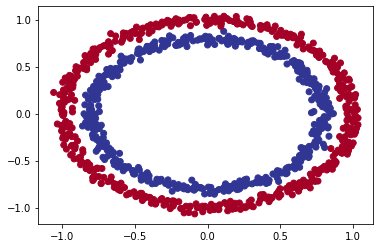

In [19]:
# Check out our data
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu);

And let's see how our model is making predictions on it.

doing binary classifcation...


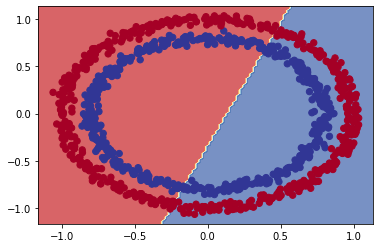

In [20]:
# Check the deicison boundary (blue is blue class, yellow is the crossover, red is red class)
plot_decision_boundary(model_4, X, y)

Well, it looks like we're getting a straight (linear) line prediction again. 

But our data is non-linear (not a straight line)...

What we're going to have to do is add some non-linearity to our model.

To do so, we'll use the `activation` parameter in on of our layers.

In [21]:
# Set random seed
tf.random.set_seed(42)

# Create a model with a non-linear activation
model_5 = tf.keras.Sequential([
  tf.keras.layers.Dense(1, activation=tf.keras.activations.relu), # can also do activation='relu'
  tf.keras.layers.Dense(1) # output layer 
])

# Compile the model
model_5.compile(loss=tf.keras.losses.binary_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history = model_5.fit(X, y, epochs=100)

Epoch 1/100
32/32 [==============================] - 1s 3ms/step - loss: 1.8377 - accuracy: 0.5000
Epoch 2/100
32/32 [==============================] - 0s 3ms/step - loss: 1.4449 - accuracy: 0.5000
Epoch 3/100
32/32 [==============================] - 0s 3ms/step - loss: 1.3410 - accuracy: 0.5000
Epoch 4/100
32/32 [==============================] - 0s 3ms/step - loss: 1.2678 - accuracy: 0.4770
Epoch 5/100
32/32 [==============================] - 0s 3ms/step - loss: 1.2116 - accuracy: 0.4390
Epoch 6/100
32/32 [==============================] - 0s 3ms/step - loss: 1.1664 - accuracy: 0.4180
Epoch 7/100
32/32 [==============================] - 0s 3ms/step - loss: 1.1294 - accuracy: 0.4250
Epoch 8/100
32/32 [==============================] - 0s 3ms/step - loss: 1.0970 - accuracy: 0.4420
Epoch 9/100
32/32 [==============================] - 0s 3ms/step - loss: 1.0670 - accuracy: 0.4540
Epoch 10/100
32/32 [==============================] - 0s 3ms/step - loss: 1.0406 - accuracy: 0.4550
Epoch 11/

Hmm... still not learning...

What we if increased the number of neurons and layers?

Say, 2 hidden layers, with [ReLU](https://www.tensorflow.org/api_docs/python/tf/keras/activations/relu), pronounced "rel-u", (short for [rectified linear unit](https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/)), activation on the first one, and 4 neurons each?

To see this network in action, check out the [TensorFlow Playground demo](https://playground.tensorflow.org/#activation=relu&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.001&regularizationRate=0&noise=0&networkShape=4,4&seed=0.93799&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&regularization_hide=true&regularizationRate_hide=true&batchSize_hide=true&dataset_hide=true).

![multi-layer neural net created with TensorFlow playground](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/02-tensorflow-playground-two-layer-net-relu-activation.png)
*The neural network we're going to recreate with TensorFlow code. See it live at [TensorFlow Playground](https://playground.tensorflow.org/#activation=relu&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.001&regularizationRate=0&noise=0&networkShape=4,4&seed=0.93799&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&regularization_hide=true&regularizationRate_hide=true&batchSize_hide=true&dataset_hide=true).*

Let's try.

In [22]:
# Set random seed
tf.random.set_seed(42)

# Create a model
model_6 = tf.keras.Sequential([
  tf.keras.layers.Dense(4, activation=tf.keras.activations.relu), # hidden layer 1, 4 neurons, ReLU activation
  tf.keras.layers.Dense(4, activation=tf.keras.activations.relu), # hidden layer 2, 4 neurons, ReLU activation
  tf.keras.layers.Dense(1) # ouput layer
])

# Compile the model
model_6.compile(loss=tf.keras.losses.binary_crossentropy,
                optimizer=tf.keras.optimizers.Adam(lr=0.001), # Adam's default learning rate is 0.001
                metrics=['accuracy'])

# Fit the model
history = model_6.fit(X, y, epochs=100)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
32/32 [==============================] - 1s 3ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 2/100
32/32 [==============================] - 0s 3ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 3/100
32/32 [==============================] - 0s 3ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 4/100
32/32 [==============================] - 0s 4ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 5/100
32/32 [==============================] - 0s 3ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 6/100
32/32 [==============================] - 0s 3ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 7/100
32/32 [==============================] - 0s 3ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 8/100
32/32 [==============================] - 0s 3ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 9/100
32/32 [==============================] - 0s 3ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 10/100
32/32 [==============================] - 0s 3ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 11/

In [23]:
# Evaluate the model
model_6.evaluate(X, y)

32/32 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.5000


[7.712474346160889, 0.5]

We're still hitting 50% accuracy, our model is still practically as good as guessing.

How do the predictions look?

doing binary classifcation...


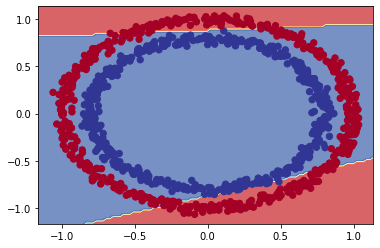

In [24]:
# Check out the predictions using 2 hidden layers
plot_decision_boundary(model_6, X, y)

What gives? 

It seems like our model is the same as the one in the [TensorFlow Playground](https://playground.tensorflow.org/#activation=relu&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,4&seed=0.93799&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&regularization_hide=true&regularizationRate_hide=true&batchSize_hide=true) but model it's still drawing straight lines... 

Ideally, the yellow lines go on the inside of the red circle and the blue circle.

Okay, okay, let's model this circle once and for all. 

One more model (I promise... actually, I'm going to have to break that promise... we'll be building plenty more models). 

This time we'll change the activation function on our output layer too. Remember the architecture of a classification model? For binary classification, the output layer activation is usually the [Sigmoid activation function](https://www.tensorflow.org/api_docs/python/tf/math/sigmoid).

In [25]:
# Set random seed
tf.random.set_seed(42)

# Create a model
model_7 = tf.keras.Sequential([
  tf.keras.layers.Dense(4, activation=tf.keras.activations.relu), # hidden layer 1, ReLU activation
  tf.keras.layers.Dense(4, activation=tf.keras.activations.relu), # hidden layer 2, ReLU activation
  tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid) # ouput layer, sigmoid activation
])

# Compile the model
model_7.compile(loss=tf.keras.losses.binary_crossentropy,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Fit the model
history = model_7.fit(X, y, epochs=100, verbose=0)

In [26]:
# Evaluate our model
model_7.evaluate(X, y)

32/32 [==============================] - 0s 2ms/step - loss: 0.2948 - accuracy: 0.9910


[0.29480040073394775, 0.9909999966621399]

Woah! It looks like our model is getting some incredible results, let's check them out.

doing binary classifcation...


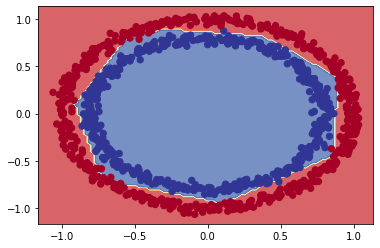

In [27]:
# View the predictions of the model with relu and sigmoid activations
plot_decision_boundary(model_7, X, y)

Nice! It looks like our model is almost perfectly (apart from a few examples) separating the two circles.

> 🤔 **Question:** What's wrong with the predictions we've made? Are we really evaluating our model correctly here? Hint: what data did the model learn on and what did we predict on?

Before we answer that, it's important to recognize what we've just covered.

> 🔑 **Note:** The combination of **linear (straight lines) and non-linear (non-straight lines) functions** is one of the key fundamentals of neural networks.

Think of it like this:

If I gave you an unlimited amount of straight lines and non-straight lines, what kind of patterns could you draw?

That's essentially what neural networks do to find patterns in data.

Now you might be thinking, "but I haven't seen a linear function or a non-linear function before..."

Oh but you have.

We've been using them the whole time.

They're what power the layers in the models we just built.

To get some intuition about the activation functions we've just used, let's create them and then try them on some toy data.

In [28]:
# Create a toy tensor (similar to the data we pass into our model)
A = tf.cast(tf.range(-10, 10), tf.float32)
A

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,
         1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.],
      dtype=float32)>

How does this look?



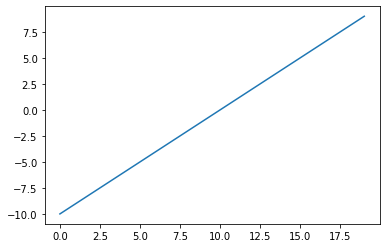

In [29]:
# Visualize our toy tensor
plt.plot(A);

A straight (linear) line!

Nice, now let's recreate the [sigmoid function](https://en.wikipedia.org/wiki/Sigmoid_function) and see what it does to our data. You can also find a pre-built sigmoid function at [`tf.keras.activations.sigmoid`](https://www.tensorflow.org/api_docs/python/tf/keras/activations/sigmoid).

In [30]:
# Sigmoid - https://www.tensorflow.org/api_docs/python/tf/keras/activations/sigmoid
def sigmoid(x):
  return 1 / (1 + tf.exp(-x))

# Use the sigmoid function on our tensor
sigmoid(A)

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([4.5397868e-05, 1.2339458e-04, 3.3535014e-04, 9.1105117e-04,
       2.4726230e-03, 6.6928510e-03, 1.7986210e-02, 4.7425874e-02,
       1.1920292e-01, 2.6894143e-01, 5.0000000e-01, 7.3105854e-01,
       8.8079703e-01, 9.5257413e-01, 9.8201376e-01, 9.9330717e-01,
       9.9752742e-01, 9.9908900e-01, 9.9966466e-01, 9.9987662e-01],
      dtype=float32)>

And how does it look?

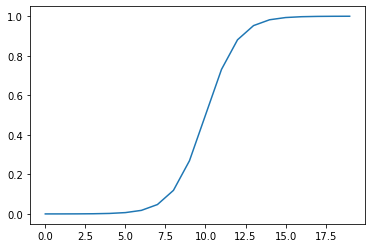

In [31]:
# Plot sigmoid modified tensor
plt.plot(sigmoid(A));

A non-straight (non-linear) line!

Okay, how about the [ReLU function](https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/#:~:text=The%20rectified%20linear%20activation%20function,otherwise%2C%20it%20will%20output%20zero.) (ReLU turns all negatives to 0 and positive numbers stay the same)?

In [32]:
# ReLU - https://www.tensorflow.org/api_docs/python/tf/keras/activations/relu
def relu(x):
  return tf.maximum(0, x)

# Pass toy tensor through ReLU function
relu(A)

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6.,
       7., 8., 9.], dtype=float32)>

How does the ReLU-modified tensor look?

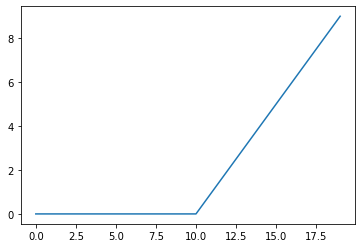

In [33]:
# Plot ReLU-modified tensor
plt.plot(relu(A));

Another non-straight line!

Well, how about TensorFlow's [linear activation function](https://www.tensorflow.org/api_docs/python/tf/keras/activations/linear)? 

In [34]:
# Linear - https://www.tensorflow.org/api_docs/python/tf/keras/activations/linear (returns input non-modified...)
tf.keras.activations.linear(A)

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,
         1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.],
      dtype=float32)>

Hmm, it looks like our inputs are unmodified...

In [35]:
# Does the linear activation change anything?
A == tf.keras.activations.linear(A)

<tf.Tensor: shape=(20,), dtype=bool, numpy=
array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])>

Okay, so it makes sense now the model doesn't really learn anything when using only linear activation functions, because the linear activation function doesn't change our input data in anyway.

Where as, with our non-linear functions, our data gets manipulated. A neural network uses these kind of transformations at a large scale to figure draw patterns between its inputs and outputs.

Now rather than dive into the guts of neural networks, we're going to keep coding applying what we've learned to different problems but if you want a more in-depth look at what's going on behind the scenes, check out the Extra Curriculum section below. 

> 📖  **Resource:** For more on activation functions, check out the [machine learning cheatsheet page](https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html#) on them.

# Evaluating and improving our classification model

If you answered the question above, you might've picked up what we've been doing wrong.

We've been evaluating our model on the same data it was trained on.

A better approach would be to split our data into training, validation (optional) and test sets.

Once we've done that, we'll train our model on the training set (let it find patterns in the data) and then see how well it learned the patterns by using it to predict values on the test set.

Let's do it.

In [36]:
# How many examples are in the whole dataset?
len(X)

1000

In [37]:
# Split data into train and test sets
X_train, y_train = X[:800], y[:800] # 80% of the data for the training set
X_test, y_test = X[800:], y[800:] # 20% of the data for the test set

# Check the shapes of the data
X_train.shape, X_test.shape # 800 examples in the training set, 200 examples in the test set 

((800, 2), (200, 2))

Great, now we've got training and test sets, let's model the training data and evaluate what our model has learned on the test set.

In [38]:
# Set random seed
tf.random.set_seed(42)

# Create the model (same as model_7)
model_8 = tf.keras.Sequential([
  tf.keras.layers.Dense(4, activation="relu"), # hidden layer 1, using "relu" for activation (same as tf.keras.activations.relu)
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(1, activation="sigmoid") # output layer, using 'sigmoid' for the output
])

# Compile the model
model_8.compile(loss=tf.keras.losses.binary_crossentropy,
                optimizer=tf.keras.optimizers.Adam(lr=0.01), # increase learning rate from 0.001 to 0.01 for faster learning
                metrics=['accuracy'])

# Fit the model
history = model_8.fit(X_train, y_train, epochs=25)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/25
25/25 [==============================] - 1s 2ms/step - loss: 0.6847 - accuracy: 0.5425
Epoch 2/25
25/25 [==============================] - 0s 3ms/step - loss: 0.6777 - accuracy: 0.5525
Epoch 3/25
25/25 [==============================] - 0s 3ms/step - loss: 0.6736 - accuracy: 0.5512
Epoch 4/25
25/25 [==============================] - 0s 3ms/step - loss: 0.6681 - accuracy: 0.5775
Epoch 5/25
25/25 [==============================] - 0s 2ms/step - loss: 0.6633 - accuracy: 0.5850
Epoch 6/25
25/25 [==============================] - 0s 2ms/step - loss: 0.6546 - accuracy: 0.5838
Epoch 7/25
25/25 [==============================] - 0s 3ms/step - loss: 0.6413 - accuracy: 0.6750
Epoch 8/25
25/25 [==============================] - 0s 3ms/step - loss: 0.6264 - accuracy: 0.7013
Epoch 9/25
25/25 [==============================] - 0s 2ms/step - loss: 0.6038 - accuracy: 0.7487
Epoch 10/25
25/25 [==============================] - 0s 2ms/step - loss: 0.5714 - accuracy: 0.7738
Epoch 11/25
25/25 [

In [39]:
# Evaluate our model on the test set
loss, accuracy = model_8.evaluate(X_test, y_test)
print(f"Model loss on the test set: {loss}")
print(f"Model accuracy on the test set: {100*accuracy:.2f}%")

7/7 [==============================] - 0s 3ms/step - loss: 0.1247 - accuracy: 1.0000
Model loss on the test set: 0.12468847632408142
Model accuracy on the test set: 100.00%


100% accuracy? Nice!

Now, when we started to create `model_8` we said it was going to be the same as `model_7` but you might've found that to be a little lie.

That's because we changed a few things: 
* **The `activation` parameter** - We used strings (`"relu"` & `"sigmoid"`) instead of using library paths (`tf.keras.activations.relu`), in TensorFlow, they both offer the same functionality.
* **The `learning_rate` (also `lr`) parameter** - We increased the **learning rate** parameter in the [Adam optimizer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) to `0.01` instead of `0.001` (an increase of 10x).
  * You can think of the learning rate as how quickly a model learns. The higher the learning rate, the faster the model's capacity to learn, however, there's such a thing as a *too high* learning rate, where a model tries to learn too fast and doesn't learn anything. We'll see a trick to find the ideal learning rate soon.
* **The number of epochs** - We lowered the number of epochs (using the `epochs` parameter) from 100 to 25 but our model still got an incredible result on both the training and test sets.
  * One of the reasons our model performed well in even less epochs (remember a single epoch is the model trying to learn patterns in the data by looking at it once, so 25 epochs means the model gets 25 chances) than before is because we increased the learning rate.

We know our model is performing well based on the evaluation metrics but let's see how it performs visually.


doing binary classifcation...
doing binary classifcation...


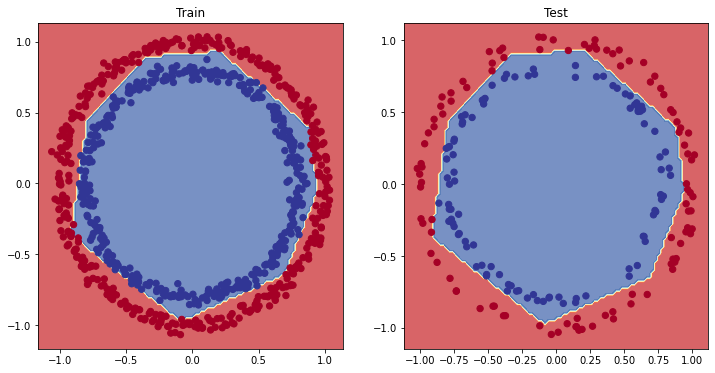

In [40]:
# Plot the decision boundaries for the training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_8, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_8, X=X_test, y=y_test)
plt.show()

Check that out! How cool. With a few tweaks, our model is now predicting the blue and red circles almost perfectly.

## Plot the loss curves

Looking at the plots above, we can see the outputs of our model are very good.

But how did our model go whilst it was learning?

As in, how did the performance change everytime the model had a chance to look at the data (once every epoch)?

To figure this out, we can check the **loss curves** (also referred to as the **learning curves**).

You might've seen we've been using the variable `history` when calling the `fit()` function on a model ([`fit()` returns a `History` object](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit)).

This is where we'll get the information for how our model is performing as it learns.

Let's see how we might use it.

In [41]:
# You can access the information in the history variable using the .history attribute
pd.DataFrame(history.history)

,loss,accuracy
0,0.684651,0.54250
1,0.677721,0.55250
2,0.673594,0.55125
3,0.668149,0.57750
4,0.663269,0.58500
5,0.654567,0.58375
6,0.641257,0.67500
7,0.626428,0.70125
8,0.603831,0.74875
9,0.571404,0.77375


Inspecting the outputs, we can see the loss values going down and the accuracy going up. 

How's it look (visualize, visualize, visualize)?

Text(0.5, 1.0, 'Model_8 training curves')

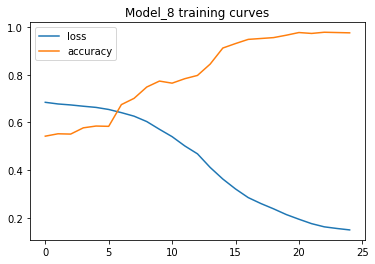

In [42]:
# Plot the loss curves
pd.DataFrame(history.history).plot()
plt.title("Model_8 training curves")

Beautiful. This is the ideal plot we'd be looking for when dealing with a classification problem, loss going down, accuracy going up.

> 🔑 **Note:** For many problems, the loss function going down means the model is improving (the predictions it's making are getting closer to the ground truth labels).

## Finding the best learning rate

Aside from the architecture itself (the layers, number of neurons, activations, etc), the most important hyperparameter you can tune for your neural network models is the **learning rate**.

In `model_8` you saw we lowered the Adam optimizer's learning rate from the default of `0.001` (default) to `0.01`.

And you might be wondering why we did this.

Put it this way, it was a lucky guess.

I just decided to try a lower learning rate and see how the model went.

Now you might be thinking, "Seriously? You can do that?"

And the answer is yes. You can change any of the hyperparamaters of your neural networks.

With practice, you'll start to see what kind of hyperparameters work and what don't.

That's an important thing to understand about machine learning and deep learning in general. It's very experimental. You build a model and evaluate it, build a model and evaluate it.

That being said, I want to introduce you a trick which will help you find the optimal learning rate (at least to begin training with) for your models going forward.

To do so, we're going to use the following:
* A [learning rate **callback**](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LearningRateScheduler).
   * You can think of a callback as an extra piece of functionality you can add to your model *while* its training.
* Another model (we could use the same ones as above, we we're practicing building models here).
* A modified loss curves plot.

We'll go through each with code, then explain what's going on.

> 🔑 **Note:** The default hyperparameters of many neural network building blocks in TensorFlow are setup in a way which usually work right out of the box (e.g. the [Adam optimizer's](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) default settings can usually get good results on many datasets). So it's a good idea to try the defaults first, then adjust as needed.

In [43]:
# Set random seed
tf.random.set_seed(42)

# Create a model (same as model_8)
model_9 = tf.keras.Sequential([
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compile the model
model_9.compile(loss="binary_crossentropy", # we can use strings here too
              optimizer="Adam", # same as tf.keras.optimizers.Adam() with default settings
              metrics=["accuracy"]) 

# Create a learning rate scheduler callback
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch/20)) # traverse a set of learning rate values starting from 1e-4, increasing by 10**(epoch/20) every epoch

# Fit the model (passing the lr_scheduler callback)
history = model_9.fit(X_train, 
                      y_train, 
                      epochs=100,
                      callbacks=[lr_scheduler])

Epoch 1/100
25/25 [==============================] - 0s 3ms/step - loss: 0.6945 - accuracy: 0.4988
Epoch 2/100
25/25 [==============================] - 0s 3ms/step - loss: 0.6938 - accuracy: 0.4975
Epoch 3/100
25/25 [==============================] - 0s 2ms/step - loss: 0.6930 - accuracy: 0.4963
Epoch 4/100
25/25 [==============================] - 0s 3ms/step - loss: 0.6922 - accuracy: 0.4975
Epoch 5/100
25/25 [==============================] - 0s 2ms/step - loss: 0.6914 - accuracy: 0.5063
Epoch 6/100
25/25 [==============================] - 0s 2ms/step - loss: 0.6906 - accuracy: 0.5013
Epoch 7/100
25/25 [==============================] - 0s 3ms/step - loss: 0.6898 - accuracy: 0.4950
Epoch 8/100
25/25 [==============================] - 0s 2ms/step - loss: 0.6889 - accuracy: 0.5038
Epoch 9/100
25/25 [==============================] - 0s 3ms/step - loss: 0.6880 - accuracy: 0.5013
Epoch 10/100
25/25 [==============================] - 0s 2ms/step - loss: 0.6871 - accuracy: 0.5050
Epoch 11/

Now our model has finished training, let's have a look at the training history.

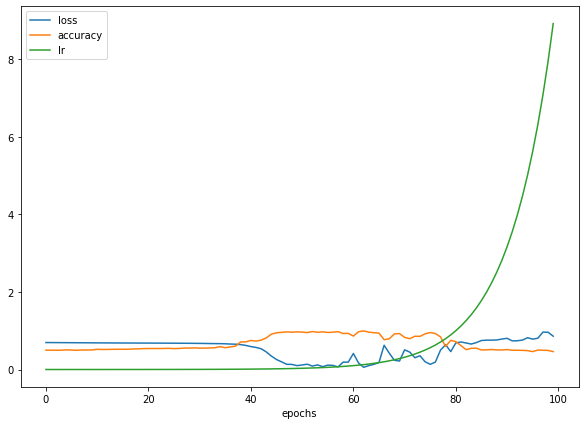

In [44]:
# Checkout the history
pd.DataFrame(history.history).plot(figsize=(10,7), xlabel="epochs");

As you you see the learning rate exponentially increases as the number of epochs increases.

And you can see the model's accuracy goes up (and loss goes down) at a specific point when the learning rate slowly increases.

To figure out where this infliction point is, we can plot the loss versus the log-scale learning rate.

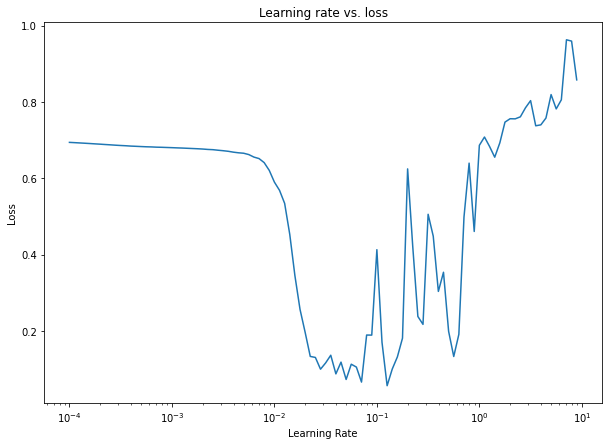

In [45]:
# Plot the learning rate versus the loss
lrs = 1e-4 * (10 ** (np.arange(100)/20))
plt.figure(figsize=(10, 7))
plt.semilogx(lrs, history.history["loss"]) # we want the x-axis (learning rate) to be log scale
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.title("Learning rate vs. loss");

To figure out the ideal value of the learning rate (at least the ideal value to *begin* training our model), the rule of thumb is to take the learning rate value where the loss is still decreasing but not quite flattened out (usually about 10x smaller than the bottom of the curve).

In this case, our ideal learning rate ends up between `0.01` ($10^{-2}$) and `0.02`.

![finding the ideal learning rate by plotting learning rate vs. loss](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/02-learning-rate-vs-loss.png)

*The ideal learning rate at the start of model training is somewhere just before the loss curve bottoms out (a value where the loss is still decreasing).*

In [46]:
# Example of other typical learning rate values
10**0, 10**-1, 10**-2, 10**-3, 1e-4

(1, 0.1, 0.01, 0.001, 0.0001)

Now we've estimated the ideal learning rate (we'll use `0.02`) for our model, let's refit it.

In [47]:
# Set the random seed
tf.random.set_seed(42)

# Create the model
model_10 = tf.keras.Sequential([
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compile the model with the ideal learning rate
model_10.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(lr=0.02), # to adjust the learning rate, you need to use tf.keras.optimizers.Adam (not "adam")
                metrics=["accuracy"])

# Fit the model for 20 epochs (5 less than before)
history = model_10.fit(X_train, y_train, epochs=20)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/20
25/25 [==============================] - 0s 2ms/step - loss: 0.6837 - accuracy: 0.5600
Epoch 2/20
25/25 [==============================] - 0s 3ms/step - loss: 0.6744 - accuracy: 0.5750
Epoch 3/20
25/25 [==============================] - 0s 2ms/step - loss: 0.6626 - accuracy: 0.5875
Epoch 4/20
25/25 [==============================] - 0s 3ms/step - loss: 0.6332 - accuracy: 0.6388
Epoch 5/20
25/25 [==============================] - 0s 2ms/step - loss: 0.5830 - accuracy: 0.7563
Epoch 6/20
25/25 [==============================] - 0s 3ms/step - loss: 0.4907 - accuracy: 0.8313
Epoch 7/20
25/25 [==============================] - 0s 2ms/step - loss: 0.4251 - accuracy: 0.8450
Epoch 8/20
25/25 [==============================] - 0s 3ms/step - loss: 0.3596 - accuracy: 0.8875
Epoch 9/20
25/25 [==============================] - 0s 2ms/step - loss: 0.3152 - accuracy: 0.9100
Epoch 10/20
25/25 [==============================] - 0s 2ms/step - loss: 0.2512 - accuracy: 0.9500
Epoch 11/20
25/25 [

Nice! With a little higher learning rate (`0.02` instead of `0.01`) we reach a higher accuracy than `model_8` in less epochs (`20` instead of `25`).

> 🛠 **Practice:** Now you've seen an example of what can happen when you change the learning rate, try changing the learning rate value in the [TensorFlow Playground](https://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.03154&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&regularization_hide=true&regularizationRate_hide=true&problem_hide=true) and see what happens. What happens if you increase it? What happens if you decrease it?



In [48]:
# Evaluate model on the test dataset
model_10.evaluate(X_test, y_test)

7/7 [==============================] - 0s 3ms/step - loss: 0.0574 - accuracy: 0.9900


[0.05740185081958771, 0.9900000095367432]



Let's see how the predictions look.

doing binary classifcation...
doing binary classifcation...


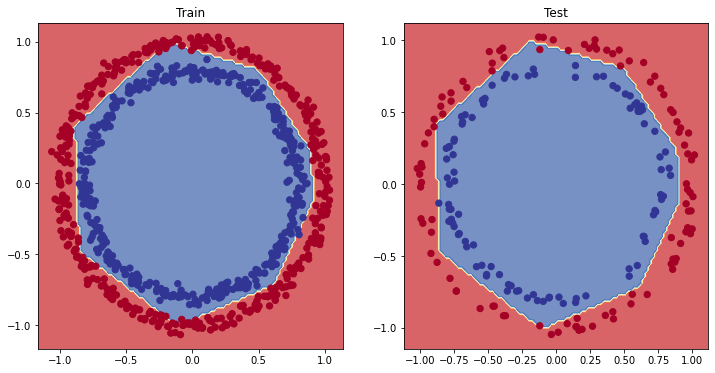

In [49]:
# Plot the decision boundaries for the training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_10, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_10, X=X_test, y=y_test)
plt.show()

And as we can see, almost perfect again.

These are the kind of experiments you'll be running often when building your own models.

Start with default settings and see how they perform on your data.

And if they don't perform as well as you'd like, improve them.

Let's look at a few more ways to evaluate our classification models.

## More classification evaluation methods

Alongside the visualizations we've been making, there are a number of different evaluation metrics we can use to evaluate our classification models.

| **Metric name/Evaluation method** | **Defintion** | **Code** |
| --- | --- | --- |
| Accuracy | Out of 100 predictions, how many does your model get correct? E.g. 95% accuracy means it gets 95/100 predictions correct. | [`sklearn.metrics.accuracy_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) or [`tf.keras.metrics.Accuracy()`](tensorflow.org/api_docs/python/tf/keras/metrics/Accuracy) |
| Precision | Proportion of true positives over total number of samples. Higher precision leads to less false positives (model predicts 1 when it should've been 0). | [`sklearn.metrics.precision_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html) or [`tf.keras.metrics.Precision()`](tensorflow.org/api_docs/python/tf/keras/metrics/Precision) |
| Recall | Proportion of true positives over total number of true positives and false negatives (model predicts 0 when it should've been 1). Higher recall leads to less false negatives. | [`sklearn.metrics.recall_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html) or [`tf.keras.metrics.Recall()`](tensorflow.org/api_docs/python/tf/keras/metrics/Recall) |
| F1-score | Combines precision and recall into one metric. 1 is best, 0 is worst. | [`sklearn.metrics.f1_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) |
| [Confusion matrix](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/)  | Compares the predicted values with the true values in a tabular way, if 100% correct, all values in the matrix will be top left to bottom right (diagnol line). | Custom function or [`sklearn.metrics.plot_confusion_matrix()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html) |
| Classification report | Collection of some of the main classification metrics such as precision, recall and f1-score. | [`sklearn.metrics.classification_report()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) |

> 🔑 **Note:** Every classification problem will require different kinds of evaluation methods. But you should be familiar with at least the ones above.

Let's start with accuracy.

Because we passed `["accuracy"]` to the `metrics` parameter when we compiled our model, calling `evaluate()` on it will return the loss as well as accuracy.

In [50]:
# Check the accuracy of our model
loss, accuracy = model_10.evaluate(X_test, y_test)
print(f"Model loss on test set: {loss}")
print(f"Model accuracy on test set: {(accuracy*100):.2f}%")

7/7 [==============================] - 0s 3ms/step - loss: 0.0574 - accuracy: 0.9900
Model loss on test set: 0.05740185081958771
Model accuracy on test set: 99.00%


How about a confusion matrix?

![anatomy of a confusion matrix](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/02-anatomy-of-a-confusion-matrix.png)
*Anatomy of a confusion matrix (what we're going to be creating). Correct predictions appear down the diagonal (from top left to bottom right).*

We can make a confusion matrix using [Scikit-Learn's `confusion_matrix`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) method.

In [51]:
# Create a confusion matrix
from sklearn.metrics import confusion_matrix

# Make predictions
y_preds = model_10.predict(X_test)

# Create confusion matrix
confusion_matrix(y_test, y_preds)

ValueError: ignored

Ahh, it seems our predictions aren't in the format they need to be.

Let's check them out.

In [52]:
# View the first 10 predictions
y_preds[:10]

array([[9.8526543e-01],
       [9.9923790e-01],
       [9.9032354e-01],
       [9.9706942e-01],
       [3.9622924e-01],
       [1.8126920e-02],
       [9.6829069e-01],
       [1.9746717e-02],
       [9.9967170e-01],
       [5.6459318e-04]], dtype=float32)

What about our test labels?

In [53]:
# View the first 10 test labels
y_test[:10]

array([1, 1, 1, 1, 0, 0, 1, 0, 1, 0])

It looks like we need to get our predictions into the binary format (0 or 1).

But you might be wondering, what format are they currently in?

In their current format (`9.8526537e-01`), they're in a form called **prediction probabilities**.

You'll see this often with the outputs of neural networks. Often they won't be exact values but more a probability of how *likely* they are to be one value or another.

So one of the steps you'll often see after making predicitons with a neural network is converting the prediction probabilities into labels.

In our case, since our ground truth labels (`y_test`) are binary (0 or 1), we can convert the prediction probabilities using to their binary form using [`tf.round()`](https://www.tensorflow.org/api_docs/python/tf/math/round).

In [54]:
# Convert prediction probabilities to binary format and view the first 10
tf.round(y_preds)[:10]

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.]], dtype=float32)>

Wonderful! Now we can use the `confusion_matrix` function.

In [55]:
# Create a confusion matrix
confusion_matrix(y_test, tf.round(y_preds))

array([[99,  2],
       [ 0, 99]])

Alright, we can see the highest numbers are down the diagonal (from top left to bottom right) so this a good sign, but the rest of the matrix doesn't really tell us much.

How about we make a function to make our confusion matrix a little more visual?

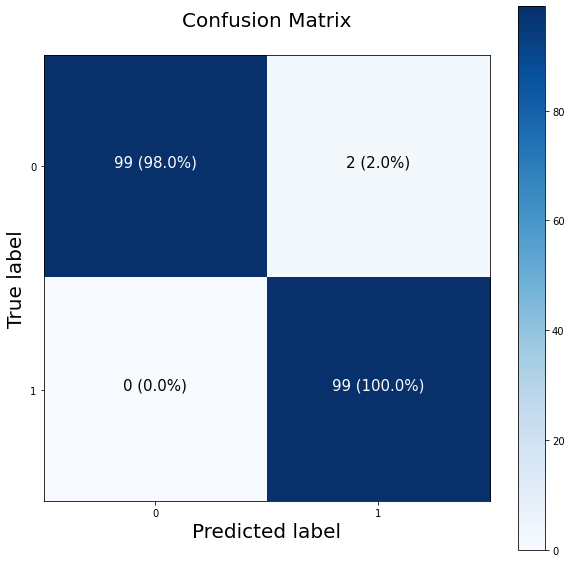

In [56]:
# Note: The following confusion matrix code is a remix of Scikit-Learn's 
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
# and Made with ML's introductory notebook - https://github.com/madewithml/basics/blob/master/notebooks/09_Multilayer_Perceptrons/09_TF_Multilayer_Perceptrons.ipynb
import itertools

figsize = (10, 10)

# Create the confusion matrix
cm = confusion_matrix(y_test, tf.round(y_preds))
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
n_classes = cm.shape[0]

# Let's prettify it
fig, ax = plt.subplots(figsize=figsize)
# Create a matrix plot
cax = ax.matshow(cm, cmap=plt.cm.Blues) # https://matplotlib.org/3.2.0/api/_as_gen/matplotlib.axes.Axes.matshow.html
fig.colorbar(cax)

# Create classes
classes = False

if classes:
  labels = classes
else:
  labels = np.arange(cm.shape[0])

# Label the axes
ax.set(title="Confusion Matrix",
       xlabel="Predicted label",
       ylabel="True label",
       xticks=np.arange(n_classes),
       yticks=np.arange(n_classes),
       xticklabels=labels,
       yticklabels=labels)

# Set x-axis labels to bottom
ax.xaxis.set_label_position("bottom")
ax.xaxis.tick_bottom()

# Adjust label size
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.title.set_size(20)

# Set threshold for different colors
threshold = (cm.max() + cm.min()) / 2.

# Plot the text on each cell
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
  plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
           horizontalalignment="center",
           color="white" if cm[i, j] > threshold else "black",
           size=15)

That looks much better. It seems our model has made almost perfect predictions on the test set except for two false positives (top right corner).

In [57]:
# What does itertools.product do? Combines two things into each combination
import itertools
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
  print(i, j)

0 0
0 1
1 0
1 1


# Working with a larger example (multiclass classification)

We've seen a binary classification example (predicting if a data point is part of a red circle or blue circle) but what if you had multiple different classes of things?

For example, say you were a fashion company and you wanted to build a neural network to predict whether a piece of clothing was a shoe, a shirt or a jacket (3 different options).

When you have more than two classes as an option, this is known as **multiclass classification**.

The good news is, the things we've learned so far (with a few tweaks) can be applied to multiclass classification problems as well.

Let's see it in action.

To start, we'll need some data. The good thing for us is TensorFlow has a multiclass classication dataset known as [Fashion MNIST built-in](https://github.com/zalandoresearch/fashion-mnist). Meaning we can get started straight away.

We can import it using the [`tf.keras.datasets`](https://www.tensorflow.org/api_docs/python/tf/keras/datasets) module.

> 📖 **Resource:** The following multiclass classification problem has been adapted from the [TensorFlow classification guide](https://www.tensorflow.org/tutorials/keras/classification). A good exercise would be to once you've gone through the following example, replicate the TensorFlow guide.

In [58]:
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist

# The data has already been sorted into training and test sets for us
(train_data, train_labels), (test_data, test_labels) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


Now let's check out an example.

In [59]:
# Show the first training example
print(f"Training sample:\n{train_data[0]}\n") 
print(f"Training label: {train_labels[0]}")

Training sample:
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   1   0   0  13  73   0
    0   1   4   0   0   0   0   1   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3   0  36 136 127  62
   54   0   0   0   1   3   4   0   0   3]
 [  0   0   0   0   0   0   0   0   0   0   0   0   6   0 102 204 176 134
  144 123  23   0   0   0   0  12  10   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 155 236 207 178
  107 156 161 109  64  23  77 130  72  15]
 [  0   0   0   0   0   0   0   0   0   0   0   1   0  69 207 223 218 216
  216 163 127 121 122 146 141  88 172  66]
 [  0   0   0   0   0   0   0   0   0   1   1  

Woah, we get a large list of numbers, followed (the data) by a single number (the class label).

What about the shapes?

In [60]:
# Check the shape of our data
train_data.shape, train_labels.shape, test_data.shape, test_labels.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [61]:
# Check shape of a single example
train_data[0].shape, train_labels[0].shape

((28, 28), ())

Okay, 60,000 training examples each with shape (28, 28) and a label each as well as 10,000 test examples of shape (28, 28).

But these are just numbers, let's visualize.

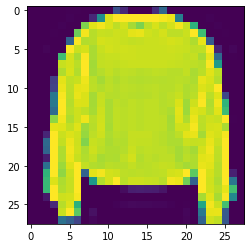

In [62]:
# Plot a single example
import matplotlib.pyplot as plt
plt.imshow(train_data[7]);

Hmm, but what about its label?

In [63]:
# Check our samples label
train_labels[7]

2

It looks like our labels are in numerical form. And while this is fine for a neural network, you might want to have them in human readable form.

Let's create a small list of the class names (we can find them on [the dataset's GitHub page](https://github.com/zalandoresearch/fashion-mnist#labels)).

> 🔑 **Note:** Whilst this dataset has been prepared for us and ready to go, it's important to remember many datasets won't be ready to go like this one. Often you'll have to do a few preprocessing steps to have it ready to use with a neural network (we'll see more of this when we work with our own data later).

In [64]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# How many classes are there (this'll be our output shape)?
len(class_names)

10

Now we have these, let's plot another example.

> 🤔 **Question:** Pay particular attention to what the data we're working with *looks* like. Is it only straight lines? Or does it have non-straight lines as well? Do you think if we wanted to find patterns in the photos of clothes (which are actually collections of pixels), will our model need non-linearities (non-straight lines) or not?

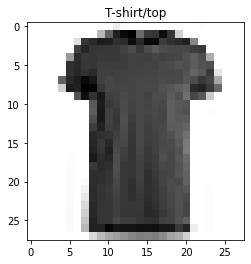

In [65]:
# Plot an example image and its label
plt.imshow(train_data[17], cmap=plt.cm.binary) # change the colours to black & white
plt.title(class_names[train_labels[17]]);

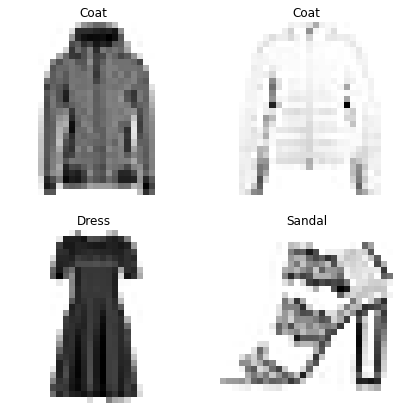

In [66]:
# Plot multiple random images of fashion MNIST
import random
plt.figure(figsize=(7, 7))
for i in range(4):
  ax = plt.subplot(2, 2, i + 1)
  rand_index = random.choice(range(len(train_data)))
  plt.imshow(train_data[rand_index], cmap=plt.cm.binary)
  plt.title(class_names[train_labels[rand_index]])
  plt.axis(False)

Alright, let's build a model to figure out the relationship between the pixel values and their labels.

Since this is a multiclass classification problem, we'll need to make a few changes to our architecture (inline with Table 1 above):

* The **input shape** will have to deal with 28x28 tensors (the height and width of our images).
  * We're actually going to squash the input into a tensor (vector) of shape `(784)`.
* The **output shape** will have to be 10 because we need our model to predict for 10 different classes.
  * We'll also change the `activation` parameter of our output layer to be [`"softmax"`](https://www.tensorflow.org/api_docs/python/tf/keras/activations/softmax) instead of `'sigmoid'`. As we'll see the `"softmax"` activation function outputs a series of values between 0 & 1 (the same shape as **output shape**, which together add up to ~1. The index with the highest value is predicted by the model to be the most *likely* class.
* We'll need to change our loss function from a binary loss function to a multiclass loss function. 
  * More specifically, since our labels are in integer form, we'll use [`tf.keras.losses.SparseCategoricalCrossentropy()`](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy), if our labels were one-hot encoded (e.g. they looked something like `[0, 0, 1, 0, 0...]`), we'd use [`tf.keras.losses.CategoricalCrossentropy()`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy).
* We'll also use the `validation_data` parameter when calling the `fit()` function. This will give us an idea of how the model performs on the test set during training.

You ready? Let's go.

In [67]:
# Set random seed
tf.random.set_seed(42)

# Create the model
model_11 = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)), # input layer (we had to reshape 28x28 to 784, the Flatten layer does this for us)
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(10, activation="softmax") # output shape is 10, activation is softmax
])

# Compile the model
model_11.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), # different loss function for multiclass classifcation
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=["accuracy"])

# Fit the model
non_norm_history = model_11.fit(train_data,
                                train_labels,
                                epochs=10,
                                validation_data=(test_data, test_labels)) # see how the model performs on the test set during training

Epoch 1/10
1875/1875 [==============================] - 5s 3ms/step - loss: 2.1781 - accuracy: 0.1599 - val_loss: 1.8123 - val_accuracy: 0.2073
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 1.7091 - accuracy: 0.2502 - val_loss: 1.6451 - val_accuracy: 0.2752
Epoch 3/10
1875/1875 [==============================] - 5s 2ms/step - loss: 1.6318 - accuracy: 0.2808 - val_loss: 1.6153 - val_accuracy: 0.2748
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 1.6114 - accuracy: 0.2859 - val_loss: 1.6039 - val_accuracy: 0.2998
Epoch 5/10
1875/1875 [==============================] - 5s 2ms/step - loss: 1.5965 - accuracy: 0.3029 - val_loss: 1.5782 - val_accuracy: 0.3202
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 1.5876 - accuracy: 0.3117 - val_loss: 1.5684 - val_accuracy: 0.3182
Epoch 7/10
1875/1875 [==============================] - 5s 2ms/step - loss: 1.5780 - accuracy: 0.3176 - val_loss: 1.5712 - val_accuracy:

In [68]:
# Check the shapes of our model
# Note: the "None" in (None, 784) is for batch_size, we'll cover this in a later module
model_11.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 4)                 3140      
_________________________________________________________________
dense_26 (Dense)             (None, 4)                 20        
_________________________________________________________________
dense_27 (Dense)             (None, 10)                50        
Total params: 3,210
Trainable params: 3,210
Non-trainable params: 0
_________________________________________________________________


Alright, our model gets to about ~35% accuracy after 10 epochs using a similar style model to what we used on our binary classification problem.

Which is better than guessing (guessing with 10 classes would result in about 10% accuracy) but we can do better.

Do you remember when we talked about neural networks preferring numbers between 0 and 1? (if not, treat this as a reminder)

Well, right now, the data we have isn't between 0 and 1, in other words, it's not normalized (hence why we used the `non_norm_history` variable when calling `fit()`). It's pixel values are between 0 and 255.

Let's see.

In [69]:
# Check the min and max values of the training data
train_data.min(), train_data.max()

(0, 255)

We can get these values between 0 and 1 by dividing the entire array by the maximum: `255.0` (dividing by a float also converts to a float).


Doing so will result in all of our data being between 0 and 1 (known as **scaling** or **normalization**).

In [70]:
# Divide train and test images by the maximum value (normalize it)
train_data = train_data / 255.0
test_data = test_data / 255.0

# Check the min and max values of the training data
train_data.min(), train_data.max()

(0.0, 1.0)

Beautiful! Now our data is between 0 and 1. Let's see what happens when we model it.

We'll use the same model as before (`model_11`) except this time the data will be normalized.

In [71]:
# Set random seed
tf.random.set_seed(42)

# Create the model
model_12 = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)), # input layer (we had to reshape 28x28 to 784)
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(10, activation="softmax") # output shape is 10, activation is softmax
])

# Compile the model
model_12.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=["accuracy"])

# Fit the model (to the normalized data)
norm_history = model_12.fit(train_data,
                            train_labels,
                            epochs=10,
                            validation_data=(test_data, test_labels))

Epoch 1/10
1875/1875 [==============================] - 5s 3ms/step - loss: 1.0348 - accuracy: 0.6474 - val_loss: 0.6937 - val_accuracy: 0.7617
Epoch 2/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.6376 - accuracy: 0.7757 - val_loss: 0.6400 - val_accuracy: 0.7820
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.5942 - accuracy: 0.7914 - val_loss: 0.6247 - val_accuracy: 0.7783
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.5750 - accuracy: 0.7979 - val_loss: 0.6078 - val_accuracy: 0.7881
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.5641 - accuracy: 0.8006 - val_loss: 0.6169 - val_accuracy: 0.7881
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.5544 - accuracy: 0.8043 - val_loss: 0.5855 - val_accuracy: 0.7951
Epoch 7/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.5488 - accuracy: 0.8063 - val_loss: 0.6097 - val_accuracy:

Woah, we used the exact same model as before but we with normalized data we're now seeing a much higher accuracy value!

Let's plot each model's history (their loss curves).

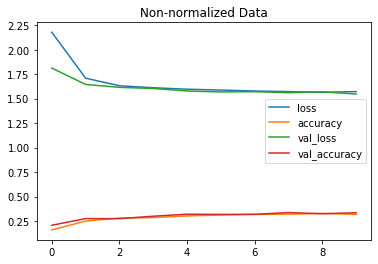

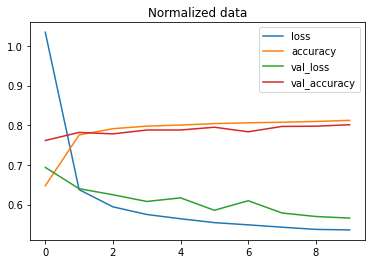

In [72]:
import pandas as pd
# Plot non-normalized data loss curves
pd.DataFrame(non_norm_history.history).plot(title="Non-normalized Data")
# Plot normalized data loss curves
pd.DataFrame(norm_history.history).plot(title="Normalized data");

Wow. From these two plots, we can see how much quicker our model with the normalized data (`model_12`) improved than the model with the non-normalized data (`model_11`).

> 🔑 **Note:** The same model with even *slightly* different data can produce *dramatically* different results. So when you're comparing models, it's important to make sure you're comparing them on the same criteria (e.g. same architecture but different data or same data but different architecture).

How about we find the ideal learning rate and see what happens?

We'll use the same architecture we've been using.

In [73]:
# Set random seed
tf.random.set_seed(42)

# Create the model
model_13 = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)), # input layer (we had to reshape 28x28 to 784)
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(10, activation="softmax") # output shape is 10, activation is softmax
])

# Compile the model
model_13.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=["accuracy"])

# Create the learning rate callback
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 10**(epoch/20))

# Fit the model
find_lr_history = model_13.fit(train_data,
                               train_labels,
                               epochs=40, # model already doing pretty good with current LR, probably don't need 100 epochs
                               validation_data=(test_data, test_labels),
                               callbacks=[lr_scheduler])

Epoch 1/40
1875/1875 [==============================] - 5s 3ms/step - loss: 1.0348 - accuracy: 0.6474 - val_loss: 0.6937 - val_accuracy: 0.7617
Epoch 2/40
1875/1875 [==============================] - 5s 3ms/step - loss: 0.6366 - accuracy: 0.7759 - val_loss: 0.6400 - val_accuracy: 0.7808
Epoch 3/40
1875/1875 [==============================] - 5s 3ms/step - loss: 0.5934 - accuracy: 0.7911 - val_loss: 0.6278 - val_accuracy: 0.7770
Epoch 4/40
1875/1875 [==============================] - 5s 3ms/step - loss: 0.5749 - accuracy: 0.7969 - val_loss: 0.6122 - val_accuracy: 0.7871
Epoch 5/40
1875/1875 [==============================] - 5s 3ms/step - loss: 0.5655 - accuracy: 0.7987 - val_loss: 0.6061 - val_accuracy: 0.7913
Epoch 6/40
1875/1875 [==============================] - 5s 2ms/step - loss: 0.5569 - accuracy: 0.8022 - val_loss: 0.5917 - val_accuracy: 0.7940
Epoch 7/40
1875/1875 [==============================] - 5s 3ms/step - loss: 0.5542 - accuracy: 0.8036 - val_loss: 0.5898 - val_accuracy:

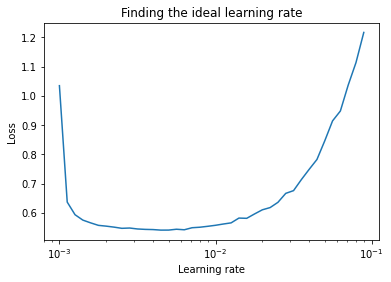

In [74]:
# Plot the learning rate decay curve
import numpy as np
import matplotlib.pyplot as plt
lrs = 1e-3 * (10**(np.arange(40)/20))
plt.semilogx(lrs, find_lr_history.history["loss"]) # want the x-axis to be log-scale
plt.xlabel("Learning rate")
plt.ylabel("Loss")
plt.title("Finding the ideal learning rate");

In this case, it looks like somewhere close to the default learning rate of the [Adam optimizer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) (`0.001`) is the ideal learning rate.

Let's refit a model using the ideal learning rate.

In [75]:
# Set random seed
tf.random.set_seed(42)

# Create the model
model_14 = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)), # input layer (we had to reshape 28x28 to 784)
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(10, activation="softmax") # output shape is 10, activation is softmax
])

# Compile the model
model_14.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                 optimizer=tf.keras.optimizers.Adam(lr=0.001), # ideal learning rate (same as default)
                 metrics=["accuracy"])

# Fit the model
history = model_14.fit(train_data,
                       train_labels,
                       epochs=20,
                       validation_data=(test_data, test_labels))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/20
1875/1875 [==============================] - 5s 3ms/step - loss: 1.0348 - accuracy: 0.6474 - val_loss: 0.6937 - val_accuracy: 0.7617
Epoch 2/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.6376 - accuracy: 0.7757 - val_loss: 0.6400 - val_accuracy: 0.7820
Epoch 3/20
1875/1875 [==============================] - 5s 2ms/step - loss: 0.5942 - accuracy: 0.7914 - val_loss: 0.6247 - val_accuracy: 0.7783
Epoch 4/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.5750 - accuracy: 0.7979 - val_loss: 0.6078 - val_accuracy: 0.7881
Epoch 5/20
1875/1875 [==============================] - 5s 2ms/step - loss: 0.5641 - accuracy: 0.8006 - val_loss: 0.6169 - val_accuracy: 0.7881
Epoch 6/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.5544 - accuracy: 0.8043 - val_loss: 0.5855 - val_accuracy: 0.7951
Epoch 7/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.5488 - accuracy: 0.8063 - val_loss: 0.6097 - val_accuracy:

Now we've got a model trained with a close-to-ideal learning rate and performing pretty well, we've got a couple of options.

We could:
* Evaluate its performance using other classification metrics (such as a [confusion matrix](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py) or [classification report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)).
* Assess some of its predictions (through visualizations).
* Improve its accuracy (by training it for longer or changing the architecture).
* Save and export it for use in an application.

Let's go through the first two options.

First we'll create a classification matrix to visualize its predictions across the different classes.

In [76]:
# Note: The following confusion matrix code is a remix of Scikit-Learn's 
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
# and Made with ML's introductory notebook - https://github.com/madewithml/basics/blob/master/notebooks/09_Multilayer_Perceptrons/09_TF_Multilayer_Perceptrons.ipynb
import itertools
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
             horizontalalignment="center",
             color="white" if cm[i, j] > threshold else "black",
             size=text_size)

Since a confusion matrix compares the truth labels (`test_labels`) to the predicted labels, we have to make some predictions with our model.

In [77]:
# Make predictions with the most recent model
y_probs = model_14.predict(test_data) # "probs" is short for probabilities

# View the first 5 predictions
y_probs[:5]

array([[8.56296631e-11, 3.53614382e-13, 2.66338357e-05, 4.63559537e-08,
        5.09496713e-05, 9.61190313e-02, 8.17780688e-08, 9.18688327e-02,
        4.06051520e-03, 8.07873845e-01],
       [3.42786166e-06, 1.28993126e-16, 9.59891379e-01, 2.05163317e-07,
        1.53292734e-02, 2.45322913e-13, 2.41429154e-02, 1.13839685e-28,
        6.32722280e-04, 4.47902337e-08],
       [6.10627758e-05, 9.96576846e-01, 4.38670682e-08, 3.34058073e-03,
        1.32495115e-05, 1.43832168e-21, 8.27903750e-06, 7.32369088e-18,
        5.48115047e-08, 4.92245879e-14],
       [7.50315085e-05, 9.90536988e-01, 4.25287766e-07, 9.22316499e-03,
        1.36231829e-04, 1.82760924e-18, 2.68083204e-05, 4.81234586e-14,
        1.45215358e-06, 2.22110386e-11],
       [7.21899271e-02, 1.54956797e-06, 2.55669028e-01, 1.03631103e-02,
        4.35412638e-02, 1.10693457e-13, 6.16930187e-01, 6.75441577e-23,
        1.30491878e-03, 1.21403820e-09]], dtype=float32)

Our model outputs a list of **prediction probabilities**, meaning, it outputs a number for how likely it thinks a particular class is to be the label.

The higher the number in the prediction probabilities list, the more likely the model believes that is the right class.

To find the highest value we can use the [`argmax()`](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html) method.

In [78]:
# See the predicted class number and label for the first example
y_probs[0].argmax(), class_names[y_probs[0].argmax()]

(9, 'Ankle boot')

Now let's do the same for all of the predictions.

In [79]:
# Convert all of the predictions from probabilities to labels
y_preds = y_probs.argmax(axis=1)

# View the first 10 prediction labels
y_preds[:10]

array([9, 2, 1, 1, 6, 1, 4, 6, 5, 7])

Wonderful, now we've got our model's predictions in label form, let's create a confusion matrix to view them against the truth labels.

In [80]:
# Check out the non-prettified confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true=test_labels, 
                 y_pred=y_preds)

array([[696,   8,  25,  87,   9,   5, 160,   0,  10,   0],
       [  2, 939,   2,  35,   9,   0,  13,   0,   0,   0],
       [ 19,   2, 656,  10, 188,   0, 110,   0,  15,   0],
       [ 39,  10,  10, 819,  55,   0,  47,   1,  19,   0],
       [  0,   0,  95,  23, 800,   0,  73,   0,   7,   2],
       [  0,   0,   1,   0,   0, 894,   0,  60,   7,  38],
       [106,   4, 158,  57, 159,   1, 499,   0,  16,   0],
       [  0,   0,   0,   0,   0,  31,   0, 936,   0,  33],
       [  4,   1,  38,  15,   8,  12,   9,   5, 906,   2],
       [  0,   0,   1,   0,   2,  15,   0,  51,   1, 930]])

That confusion matrix is hard to comprehend, let's make it prettier using the function we created before.

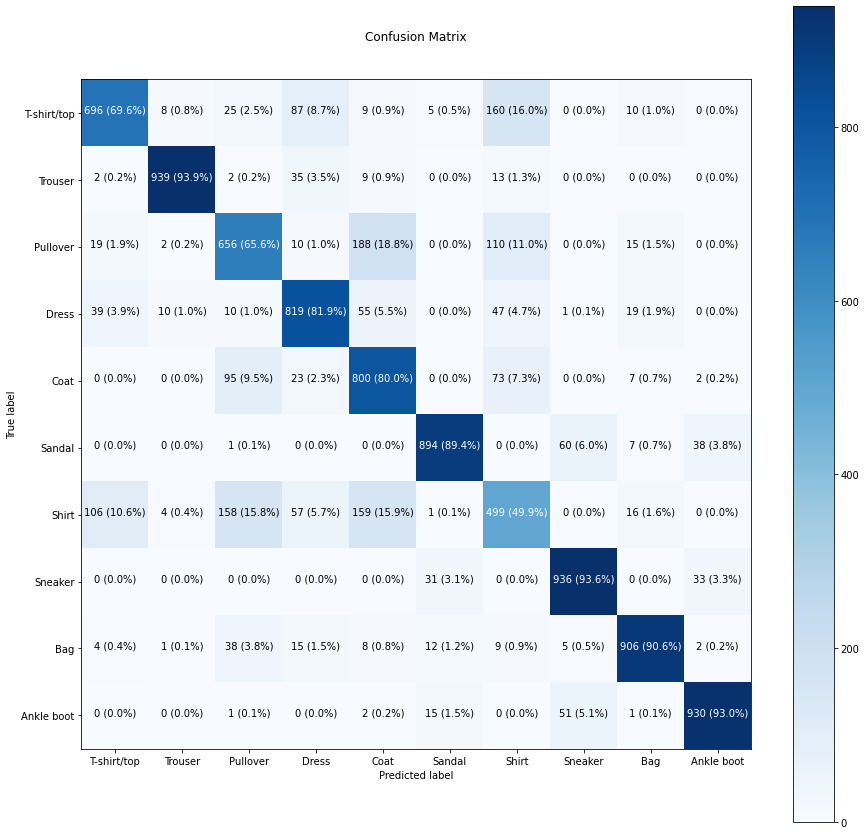

In [81]:
# Make a prettier confusion matrix
make_confusion_matrix(y_true=test_labels, 
                      y_pred=y_preds,
                      classes=class_names,
                      figsize=(15, 15),
                      text_size=10)

That looks much better! (one of my favourites sights in the world is a confusion matrix with dark squares down the diagonal)

Except the results aren't as good as they could be...

It looks like our model is getting confused between the `Shirt` and `T-shirt/top` classes (e.g. predicting `Shirt` when it's actually a `T-shirt/top`).

> 🤔 **Question:** Does it make sense that our model is getting confused between the `Shirt` and `T-shirt/top` classes? Why do you think this might be? What's one way you could investigate?

We've seen how our models predictions line up to the truth labels using a confusion matrix, but how about we visualize some?

Let's create a function to plot a random image along with its prediction.

> 🔑 **Note:** Often when working with images and other forms of visual data, it's a good idea to visualize as much as possible to develop a further understanding of the data and the outputs of your model.

In [82]:
 import random

# Create a function for plotting a random image along with its prediction
def plot_random_image(model, images, true_labels, classes):
  """Picks a random image, plots it and labels it with a predicted and truth label.

  Args:
    model: a trained model (trained on data similar to what's in images).
    images: a set of random images (in tensor form).
    true_labels: array of ground truth labels for images.
    classes: array of class names for images.
  
  Returns:
    A plot of a random image from `images` with a predicted class label from `model`
    as well as the truth class label from `true_labels`.
  """ 
  # Setup random integer
  i = random.randint(0, len(images))
  
  # Create predictions and targets
  target_image = images[i]
  pred_probs = model.predict(target_image.reshape(1, 28, 28)) # have to reshape to get into right size for model
  pred_label = classes[pred_probs.argmax()]
  true_label = classes[true_labels[i]]

  # Plot the target image
  plt.imshow(target_image, cmap=plt.cm.binary)

  # Change the color of the titles depending on if the prediction is right or wrong
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"

  # Add xlabel information (prediction/true label)
  plt.xlabel("Pred: {} {:2.0f}% (True: {})".format(pred_label,
                                                   100*tf.reduce_max(pred_probs),
                                                   true_label),
             color=color) # set the color to green or red

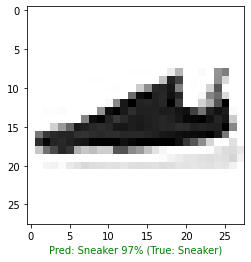

In [83]:
# Check out a random image as well as its prediction
plot_random_image(model=model_14, 
                  images=test_data, 
                  true_labels=test_labels, 
                  classes=class_names)

After running the cell above a few times you'll start to get a visual understanding of the relationship between the model's predictions and the true labels.

Did you figure out which predictions the model gets confused on?

It seems to mix up classes which are similar, for example, `Sneaker` with `Ankle boot`.

Looking at the images, you can see how this might be the case.

The overall shape of a `Sneaker` and an `Ankle Boot` are similar.

The overall shape might be one of the patterns the model has learned and so therefore when two images have a similar shape, their predictions get mixed up.

## What patterns is our model learning?

We've been talking a lot about how a neural network finds patterns in numbers, but what exactly do these patterns look like?

Let's crack open one of our models and find out.

First, we'll get a list of layers in our most recent model (`model_14`) using the `layers` attribute.

In [84]:
# Find the layers of our most recent model
model_14.layers

We can access a target layer using indexing.

In [85]:
# Extract a particular layer
model_14.layers[1]

And we can find the patterns learned by a particular layer using the `get_weights()` method.

The `get_weights()` method returns the **weights** (also known as a weights matrix) and biases (also known as a bias vector) of a particular layer.

In [86]:
# Get the patterns of a layer in our network
weights, biases = model_14.layers[1].get_weights()

# Shape = 1 weight matrix the size of our input data (28x28) per neuron (4)
weights, weights.shape

(array([[ 0.71502626, -0.06077131, -0.9976306 , -1.0484313 ],
        [ 0.2773215 , -0.47155505, -0.52916485,  0.02329273],
        [ 0.7752433 ,  0.54027516, -1.1288564 , -0.7426152 ],
        ...,
        [-0.39453337,  0.47628665, -0.22641583,  0.25505972],
        [-0.40515754,  0.61810017,  0.23928377, -0.5038761 ],
        [ 0.2388459 ,  0.11606904, -0.12131393,  0.04352449]],
       dtype=float32), (784, 4))

The weights matrix is the same shape as the input data, which in our case is 784 (28x28 pixels). And there's a copy of the weights matrix for each neuron the in the selected layer (our selected layer has 4 neurons).

Each value in the weights matrix corresponds to how a particular value in the input data influences the network's decisions.

These values start out as random numbers (they're set by the [`kernel_initializer` parameter](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) when creating a layer, the default is [`"glorot_uniform"`](https://www.tensorflow.org/api_docs/python/tf/keras/initializers/GlorotUniform)) and are then updated to better representative values of the data (non-random) by the neural network during training.

![neural network supervised learning weight updates](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/02-fashion-mnist-learning.png)
*Example workflow of how a supervised neural network starts with random weights and updates them to better represent the data by looking at examples of ideal outputs.*

Now let's check out the bias vector.

In [87]:
# Shape = 1 bias per neuron (we use 4 neurons in the first layer)
biases, biases.shape

(array([ 2.4485828e-02, -6.1484711e-04, -2.7230161e-01,  8.1124914e-01],
       dtype=float32), (4,))

Every neuron has a bias vector. Each of these is paired with a weight matrix.

The bias values get initialized as zeroes by default (using the [`bias_initializer` parameter](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)).

The bias vector dictates how much the patterns within the corresponding weights matrix should influence the next layer.

In [88]:
# Can now calculate the number of paramters in our model
model_14.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 4)                 3140      
_________________________________________________________________
dense_35 (Dense)             (None, 4)                 20        
_________________________________________________________________
dense_36 (Dense)             (None, 10)                50        
Total params: 3,210
Trainable params: 3,210
Non-trainable params: 0
_________________________________________________________________


Now we've built a few deep learning models, it's a good time to point out the whole concept of inputs and outputs not only relates to a model as a whole but to *every* layer within a model.

You might've already guessed this, but starting from the input layer, each subsequent layer's input is the output of the previous layer.

We can see this clearly using the utility [`plot_model()`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/plot_model).

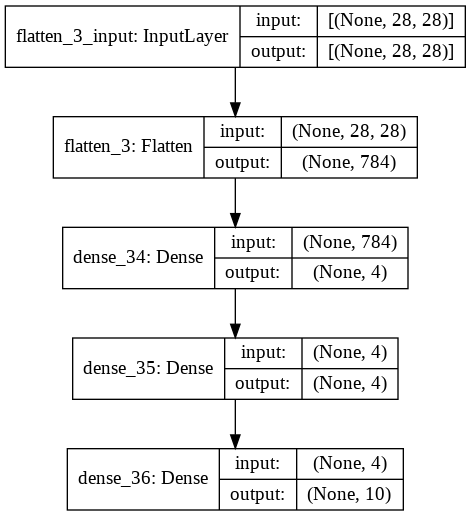

In [89]:
from tensorflow.keras.utils import plot_model

# See the inputs and outputs of each layer
plot_model(model_14, show_shapes=True)

# How a model learns (in brief)

Alright, we've trained a bunch of models, but we've never really discussed what's going on under the hood. So how exactly does a model learn?

A model learns by updating and improving its weight matrices and biases values every epoch (in our case, when we call the `fit()` fucntion).

It does so by comparing the patterns its learned between the data and labels to the actual labels.

If the current patterns (weight matrices and bias values) don't result in a desirable decrease in the loss function (higher loss means worse predictions), the optimizer tries to steer the model to update its patterns in the right way (using the real labels as a reference).

This process of using the real labels as a reference to improve the model's predictions is called [**backpropagation**](https://en.wikipedia.org/wiki/Backpropagation).

In other words, data and labels pass through a model (**forward pass**) and it attempts to learn the relationship between the data and labels. 

And if this learned relationship isn't close to the actual relationship or it could be improved, the model does so by going back through itself (**backward pass**) and tweaking its weights matrices and bias values to better represent the data.

If all of this sounds confusing (and it's fine if it does, the above is a very succinct description), check out the resources in the extra-curriculum section for more.

# Exercises 🛠

1. Play with neural networks in the [TensorFlow Playground](https://playground.tensorflow.org/) for 10-minutes. Especially try different values of the learning, what happens when you decrease it? What happens when you increase it?
2. Replicate the model pictured in the [TensorFlow Playground diagram](https://playground.tensorflow.org/#activation=relu&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.001&regularizationRate=0&noise=0&networkShape=6,6,6,6,6&seed=0.51287&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&regularization_hide=true&discretize_hide=true&regularizationRate_hide=true&percTrainData_hide=true&dataset_hide=true&problem_hide=true&noise_hide=true&batchSize_hide=true) below using TensorFlow code. Compile it using the Adam optimizer, binary crossentropy loss and accuracy metric. Once it's compiled check a summary of the model.
![tensorflow playground example neural network](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/02-tensorflow-playground-replication-exercise.png)
*Try this network out for yourself on the [TensorFlow Playground website](https://playground.tensorflow.org/#activation=relu&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.001&regularizationRate=0&noise=0&networkShape=6,6,6,6,6&seed=0.51287&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&regularization_hide=true&discretize_hide=true&regularizationRate_hide=true&percTrainData_hide=true&dataset_hide=true&problem_hide=true&noise_hide=true&batchSize_hide=true). Hint: there are 5 hidden layers but the output layer isn't pictured, you'll have to decide what the output layer should be based on the input data.*
3. Create a classification dataset using Scikit-Learn's [`make_moons()`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) function, visualize it and then build a model to fit it at over 85% accuracy.
4. Create a function (or write code) to visualize multiple image predictions for the fashion MNIST at the same time. Plot at least three different images and their prediciton labels at the same time. Hint: see the [classifcation tutorial in the TensorFlow documentation](https://www.tensorflow.org/tutorials/keras/classification) for ideas.
5. Recreate [TensorFlow's](https://www.tensorflow.org/api_docs/python/tf/keras/activations/softmax) [softmax activation function](https://en.wikipedia.org/wiki/Softmax_function) in your own code. Make sure it can accept a tensor and return that tensor after having the softmax function applied to it.
6. Train a model to get 88%+ accuracy on the fashion MNIST test set. Plot a confusion matrix to see the results after.
7. Make a function to show an image of a certain class of the fashion MNIST dataset and make a prediction on it. For example, plot 3 images of the `T-shirt` class with their predictions.

